This document's link: https://colab.research.google.com/drive/1GEoQnlalGtxDLSzkmmUSo5ulZg2RbtVe


# Sparse binary Distributed Representation

A *sparse* vector is a vector in which most of the elements are zero.

A *binary sparse* vector is a vector in which most of the elements are zero and the remaining elements are ones.

The representation is *distributed* when each unit is involved in coding more than one familiar “thing”, and consequently, from a neuroscience perspective, the identity of a stimulus cannot be determined from the activation of a single unit.

In [0]:
import numpy as np

sparseness = 0.05  # 5% of cells are active, on average

sdr = np.random.binomial(n=1, p=sparseness, size=100)  # binary SDR
print(sdr)


[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## How to form Sparse binary Distributed Representation (SDR)

The computational model of having binary SDR comes from neurobiology, where it has been shown that in our brain only a small fraction of neurons are active each time ([Young & Yamane, 1992](https://www.ncbi.nlm.nih.gov/pubmed/1598577)). Since neurons activations are physically constrained to either fire (logical 1) or not (logical 0), it makes sense to investigate what advantages, if any, such data representation leverages over commonly used dense coding.

**From this point, I'll drop the word "binary" and will use just SDR, meaning that it's binary SDR.**

The simplest way to achieve SDR is with *k-winners-take-all* (kWTA) algorithm, which consists of three steps:

1. Find $k$ largest values in the input array.
2. Set them to one, if you want your output values to be binary.
3. Set the rest elements to zero.

For example, `kWTA([7.1, 0.0, -2.3, 9.8, 4.5, 0.7], k=3) == [1, 0, 0, 1, 1, 0]`




In [0]:
import numpy as np


def kWTA(vector, k):
    """
    :param vector: array-like vector of real values
    :param k: (int) num. of active units to keep
    :return: binary SDR with the top `k` elements set to 1 and the rest to 0
    """
    # your code goes here
    return vector


print(kWTA([7.1, 0.0, -2.3, 9.8, 4.5, 0.7], k=3))

[1 0 0 1 1 0]


kWTA implicitly models inhibition process by selecting the most $k$ activate neurons from a population that, once become active, inhibit the rest of neurons. From a computational perspective, this algorithm is simple and can be implemented efficiently.

But if directly apply this algorithm to a dense vector (a vector in which most of the values are nonzero), we lose $1-{k \over n}$ information. When $k \ll n$, which is our case, we lose almost all the information. To overcome this problem, we do dimensionality expansion $X \to Y$, where $\text{dim}(Y) \gg \text{dim}(X)$. Then, if the representation in $Y$ is distributed, each neuron carries a little information about *all* input neurons, and a group of active units in $Y$ is able to restore the input data $X$.

The simplest and cruelest way to do dimensionality expansion is to multiply the input by a large random weight matrix $\pmb{W}$ and apply kWTA:

$\pmb{y} = \text{kWTA}(\pmb{Wx}, k)$

### Inverse kWTA

To illustrate that this actually works, I'll show you one nice thing about kWTA - the inverse of kWTA function is also kWTA! This is true when the information, stored in the input, is represented by the neurons with positive values:

If $\pmb{x}$ is a binary vector and $\pmb{y} = \text{kWTA}(\pmb{Wx},k)$ such that $\text{dim}(\pmb{y}) \gg \text{dim}(\pmb{x})$, then $\pmb{x_{reconstructed}} = \text{kWTA}(\pmb{W^Ty}, k_{input}) \approx \pmb{x}$, where $k$ can be any small value and $k_{input}$ should match the sparsness of the (dense) input data.

In [0]:
# install MNIST data loader
!pip install mnist==0.2.2

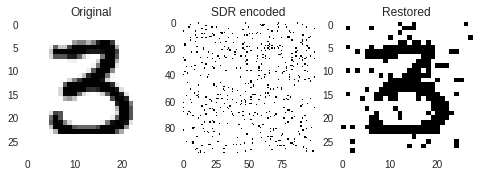

In [0]:
import mnist
import random
import math
import matplotlib.pyplot as plt
from functools import lru_cache


images = mnist.train_images()


@lru_cache(maxsize=32, typed=False)
def factors_root(number: int):
    """
    :param number: an integer value
    :return: two integer factors, closest to the square root of the input
    """
    root = int(math.sqrt(number))
    for divisor in range(root, 0, -1):
        if number % divisor == 0:
            return divisor, number // divisor
    return 1, number


def kwta_inverse(sdr_size=10000, sparsity=0.05):
    """
    :param sdr_size: size of the SDR encoding of the input data
    :param sparsity: SDR vector sparsity
    """
    image = random.choice(images)

    # num of active units in encoded SDR vector
    k_active = math.ceil(kwta_size * sparsity)
    # num of active units in the input image
    k_active_input = np.count_nonzero(image)
    
    # random weights matrix; any distribution works
    weights = np.random.binomial(n=1, p=sparsity, size=(sdr_size, image.size))
    # weights = np.random.randn(sdr_size, image.size)
    
    # encoded SDR vector of the image
    sdr = kWTA(weights.dot(image.flatten()), k=k_active)
    
    # image, restored from its SDR
    image_restored = kWTA(weights.T.dot(sdr), k=k_active_input)
    image_restored = image_restored.reshape(image.shape)
    
    return image, sdr, image_restored


def show_kwta_inverse():
    image, sdr, image_restored = kwta_inverse()
    
    # reshape to a square image
    sdr = sdr.reshape(factors_root(sdr.size))
    
    plt.subplot(131)
    plt.title("Original")
    plt.grid(False)
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title("SDR encoded")
    plt.grid(False)
    plt.imshow(sdr)
    
    plt.subplot(133)
    plt.title("Restored")
    plt.grid(False)
    plt.imshow(image_restored)
    plt.show()

    
show_kwta_inverse()


If we apply kWTA directly to the input data, we lose $\approx 1 - {k \over {k_{input}}} $ bits unless we use a strategy, different from keeping top $k$ values only. For MNIST data, one of such sophistaced strategies could be selecting $k$ points with equally distributed distances between each other.

### Random-kWTA forms translation _variant_ representation

Although multiplying by a large random matrix and taking top $k$ values does make binary sparse distributed representation, it suffers from any transformations: rotation, translation, shear, scale, etc. One of the properties that any embedding vector should have is similarity to small input changes. To make SDRs transformation invariant, the weights matrix has to be learnable. And this is the topic of the next [section](https://colab.research.google.com/drive/1e8AYGMaIfywB3hau8hOvniIvn4JOvAcj), where we add kWTA on top of a regular neural network.


## Willshaw's associative memory

One of the simplest Hebbian-like learning rules is Willshaw's associative memory.

Say you want to store a sequence of events in a memory such that one event retrieves all subsequent events. Or your data come from different modalities, visual (image) and audio inputs, and you want to connect visual data with audio such that, when a particular image is presentent, the appropriate audio sound is retrieved or vice versa.

Let visual and audio information is encoded in sparse binary vectors $\pmb{x}$ and $\pmb{y}$ respectively. Then, an event  $E$ of explosion might be encoded as a union $E = \{ \pmb{x}, \pmb{y} \}$. Now we want to write this event in a memory in such a way that the sound of an explosion $\pmb{y}$ retrieves the encoding of visual image $\pmb{x}$. Let $\otimes$ denotes the outer product between two vectors. Then, since

$(\pmb{x} \otimes \pmb{y}) \pmb{y} = \pmb{x} * (\pmb{y}\pmb{y^T}) \propto \pmb{x}$,

we can create an update rule for the memory matrix $\pmb{W}$:

$\pmb{W} = \pmb{W} + \pmb{x} \otimes \pmb{y}$

In Willshaw's model, elements of $\pmb{W}$ are constrained to be either 0 or 1. So we apply a unit step function:

$\pmb{W} = \Theta(\pmb{W})$,

where $\Theta(x) = 1 ~~ \text{if} ~~ x > 0$; otherwise it is zero.

To retrieve $\pmb{x}$ when $\pmb{y}$ is present,

$\pmb{x} = \Theta(\pmb{W} \pmb{y})$


Events $\pmb{x}$ and $\pmb{y}$ should not necessarily represent different modalities. The same mechanism applies for time related events:

$\pmb{W} =\Theta( \pmb{W} + \pmb{x_{t-1}} \otimes \pmb{x_t})$

The update rule is local and, therefore, biologically plausible. The matrix elements are constrained to be binary on purpose - to increase the capacity of the model - the number of stored and correctly retrieved patterns per one bit. In machine learning, it's common to use dense float matricies. To make the comparison between Willshaw's model and a regular dense real-valued matrices, we need to increase the number of bits in Willshaw's model (not shown here).


WIth the ability to merge subsequent SDRs in one vector (word's representation as a generalization of a sequence of letters), we can predict the future at the arbitrary time moment $T$. There are two common ways to achive that:
 
1. Recursive step-by-step prediction. To predict what will happen after $T$ time steps, we need to know what should happen after $T-1$ time steps and thus we must predict all time steps from the current point $T_0$ to $T_0 + T$. This way is taken in machine learning community. Numenta has a dedicated [Heirarchical Temporal Memory](https://numenta.com/resources/biological-and-machine-intelligence/temporal-memory-algorithm/) (HTM) framework for this. As a side note, kWTA is heavily used in HTM.
2. Instantaneous prediction at any time step scale. In Numenta's Heirarchical Temporal Memory framework, it's called [Temporal Pooler](https://github.com/numenta/htmresearch/wiki/Overview-of-the-Temporal-Pooler) (not implemented yet).

Theoretically, these both ways could be implemented with Willshaw's learning rule by associating not subsuqent $x_{t-1}$ and $x_t$ events only but including (all?) previous ones.


100%|██████████| 2000/2000 [00:03<00:00, 646.46it/s]


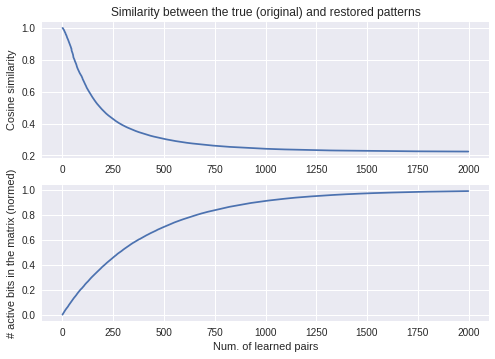

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

sparsity = 0.05
n_patterns = 2000
size = 1000

bernoulli_sampler = Bernoulli(probs=sparsity)
dict_patterns = bernoulli_sampler.sample([n_patterns, size]).to(device=device)
weights = torch.zeros(size, size, device=device)

pair_indices = torch.randint(low=0, high=n_patterns, size=(n_patterns, 2), device=device)
pairs_to_learn = dict_patterns[pair_indices]

similarity = []
weights_bits_active = []


def get_similarity(pairs_learned):
    patterns_orig = pairs_learned[:, 0]
    patterns_retrieved = pairs_learned[:, 1] @ weights.transpose(0, 1)
    sim = F.cosine_similarity(patterns_orig, patterns_retrieved, dim=1).mean()
    return sim


for trial, (left, right) in enumerate(tqdm(pair_indices)):
    pattern_left, pattern_right = pairs_to_learn[trial]
    weights += torch.ger(pattern_left, pattern_right)  # outer product
    weights.clamp_max_(1.0)
    trial_similarity = get_similarity(pairs_learned=pairs_to_learn[:trial + 1])
    similarity.append(trial_similarity)
    weights_bits_active.append(weights.mean())


plt.subplot(211)
plt.plot(range(n_patterns), similarity)
plt.ylabel('Cosine similarity')
plt.title('Similarity between the true (original) and restored patterns')

plt.subplot(212)
plt.plot(range(n_patterns), weights_bits_active)
plt.ylabel('# active bits in the matrix (normed)')
plt.xlabel('Num. of learned pairs')
plt.show()


As expected, the more pattern pairs are stored in a memory, more bit cells of the matrix are filled and, consequently, more errors and spurious patterns are retrieved instead of the original ones.


## SDR subsampling and ability to reconstruct the pattern by a partial match

Another beautiful property of SDR, which we won't discuss now, is its ability to reconstruct a pattern by a partial match, using latteral connections (recurrent connections between neurons in one layer). For example, Willshaw's model doesn't require us associating the full SDR vectors. Instead, we can _subsample_ $k < k_{active}$ neurons from $k_{active}$  active neurons and try associating only them. Then, latteral connections reconstuct the missing active neurons. Here is the same idea taken from HTM community ([link to pdf](https://numenta.com/assets/pdf/temporal-memory-algorithm/Temporal-Memory-Algorithm-Details.pdf)):

> Assume we have a hypothetical layer that always forms representations by using 200 active cells out of
a total of 10,000 cells (2% of the cells are active at any time). How can we remember and recognize a
particular pattern of 200 active cells? A simple way to do this is to make a list of the 200 active cells we
care about. If we see the same 200 cells active again we recognize the pattern. However, what if we
made a list of only 20 of the 200 active cells and ignored the other 180? What would happen? You
might think that remembering only 20 cells would cause lots of errors, that those 20 cells would be
active in many different patterns of 200. But this isn’t the case. Because the patterns are large and
sparse (in this example 200 active cells out of 10,000), remembering 20 active cells is almost as good as
remembering all 200. The chance for error in a practical system is exceedingly small and we have
reduced our memory needs considerably. 